In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
from astropy import units as u
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from starkit.fix_spectrum1d import SKSpectrum1D
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from specutils import Spectrum1D,rvmeasure
import datetime,glob
import model_tester_updated as mt

In [2]:
#This cell loads the data and the model grid. It then concatenates the grid to the model parameters such as 
#v_rad, v_rot. All data is used here, with no masking



specdir = '/u/ghezgroup/data/metallicity/nirspec/spectra/'
testspec_list = specdir+'NGC6791_J19205+3748282_order35*.dat'
testspec_path = glob.glob(testspec_list)

snr = 50.

starspectrumall = read_fits_file.read_nirspec_dat(testspec_path,desired_wavelength_units='micron')
    
waverange = [np.amin(starspectrumall.wavelength.value[:970]), np.amax(starspectrumall.wavelength.value[:970])]
starspectrum35 = read_fits_file.read_nirspec_dat(testspec_path,desired_wavelength_units='Angstrom',
                                                 wave_range=waverange)
starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value))+1.0/np.float(snr))*starspectrum35.flux.unit

print testspec_path

g = load_grid('/u/rbentley/metallicity/grids/phoenix_t2000_6000_w21500_22220_R40000.h5')

w,f = g()

testspec_w = np.linspace(w[0],w[-1],np.amax(w)-np.amin(w))
testspec_f = np.ones(len(testspec_w))
testspec_u = np.ones(len(testspec_w))*0.001
testspec = SKSpectrum1D.from_array(wavelength=testspec_w*u.angstrom, flux=testspec_f*u.Unit('erg/s/cm^2/angstrom'), uncertainty=testspec_u*u.Unit('erg/s/cm^2/angstrom'))


interp1 = Interpolate(starspectrum35)
convolve1 = InstrumentConvolveGrating.from_grid(g,R=24000)
rot1 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
norm1 = Normalize(starspectrum35,2)

# concatenate the spectral grid (which will have the stellar parameters) with other 
# model components that you want to fit
model = g | rot1 |DopplerShift(vrad=0.0)| convolve1 | interp1 | norm1

# add likelihood parts
like1 = Chi2Likelihood(starspectrum35)
#like1_l1 = SpectralL1Likelihood(spectrum)

fit_model = model | like1

clipping [2.1811267999999999, 2.2103229]
['/u/ghezgroup/data/metallicity/nirspec/spectra/NGC6791_J19205+3748282_order35_nod1.dat', '/u/ghezgroup/data/metallicity/nirspec/spectra/NGC6791_J19205+3748282_order35_nod2.dat']
[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (12800, 5271) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)
[py.warnings         ][WARNING]  /u/rbentle

In [3]:
'''
interp2 = Interpolate(starspectrum35)
convolve2 = InstrumentConvolveGrating.from_grid(g,R=24000)
rot2 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
norm2 = Normalize(starspectrum35,2)
like2 = Chi2Likelihood(starspectrum35)
                         
fit_model = g | rot2 |DopplerShift(vrad=0.0)| convolve2 | interp2 | norm2
fit_model_like = fit_model | like2

'''


'\ninterp2 = Interpolate(starspectrum35)\nconvolve2 = InstrumentConvolveGrating.from_grid(g,R=24000)\nrot2 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))\nnorm2 = Normalize(starspectrum35,2)\nlike2 = Chi2Likelihood(starspectrum35)\n                         \nfit_model = g | rot2 |DopplerShift(vrad=0.0)| convolve2 | interp2 | norm2\nfit_model_like = fit_model | like2\n\n'

In [4]:
#This is the fit itself. gc_result is a set of parameters from the best MultiNest fit to the data. 
#This cell takes time to evaluate.

gc_result = mt.run_multinest_fit(fit_model)



here
here
[starkit.fitkit.multinest.base][INFO   ]  Starting fit in /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpUgS75G with prefix specgrid_multinest (base.py:307)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/starkit/base/operations/spectrograph.py:192: UserWarning: The fit may be poorly conditioned
  warnings.warn(msg)
 (spectrograph.py:192)
[starkit.fitkit.multinest.base][INFO   ]  Fit finished - took 368.25 s (base.py:314)
[starkit.fitkit.multinest.base][INFO   ]  Cleaning up - deleting /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpUgS75G (base.py:322)
teff_0      3891.050138
logg_0         0.103960
mh_0           0.004661
alpha_0        0.306274
vrot_1         0.909221
vrad_2       140.604152
R_3        24000.000000
dtype: float64
teff_0      3889.381865
logg_0         0.105960
mh_0           0.006432
alpha_0        0.305366
vrot_1         0.925930
vrad_2       140.599341
R_3        24000.000000
dtype: float64 end


chi squared val  Model: SpectralChi2Likelihood
Inputs: ('wavelength', 'flux')
Outputs: ('loglikelihood',)
Model set size: 1
Parameters:

968 968
0.00466062175262


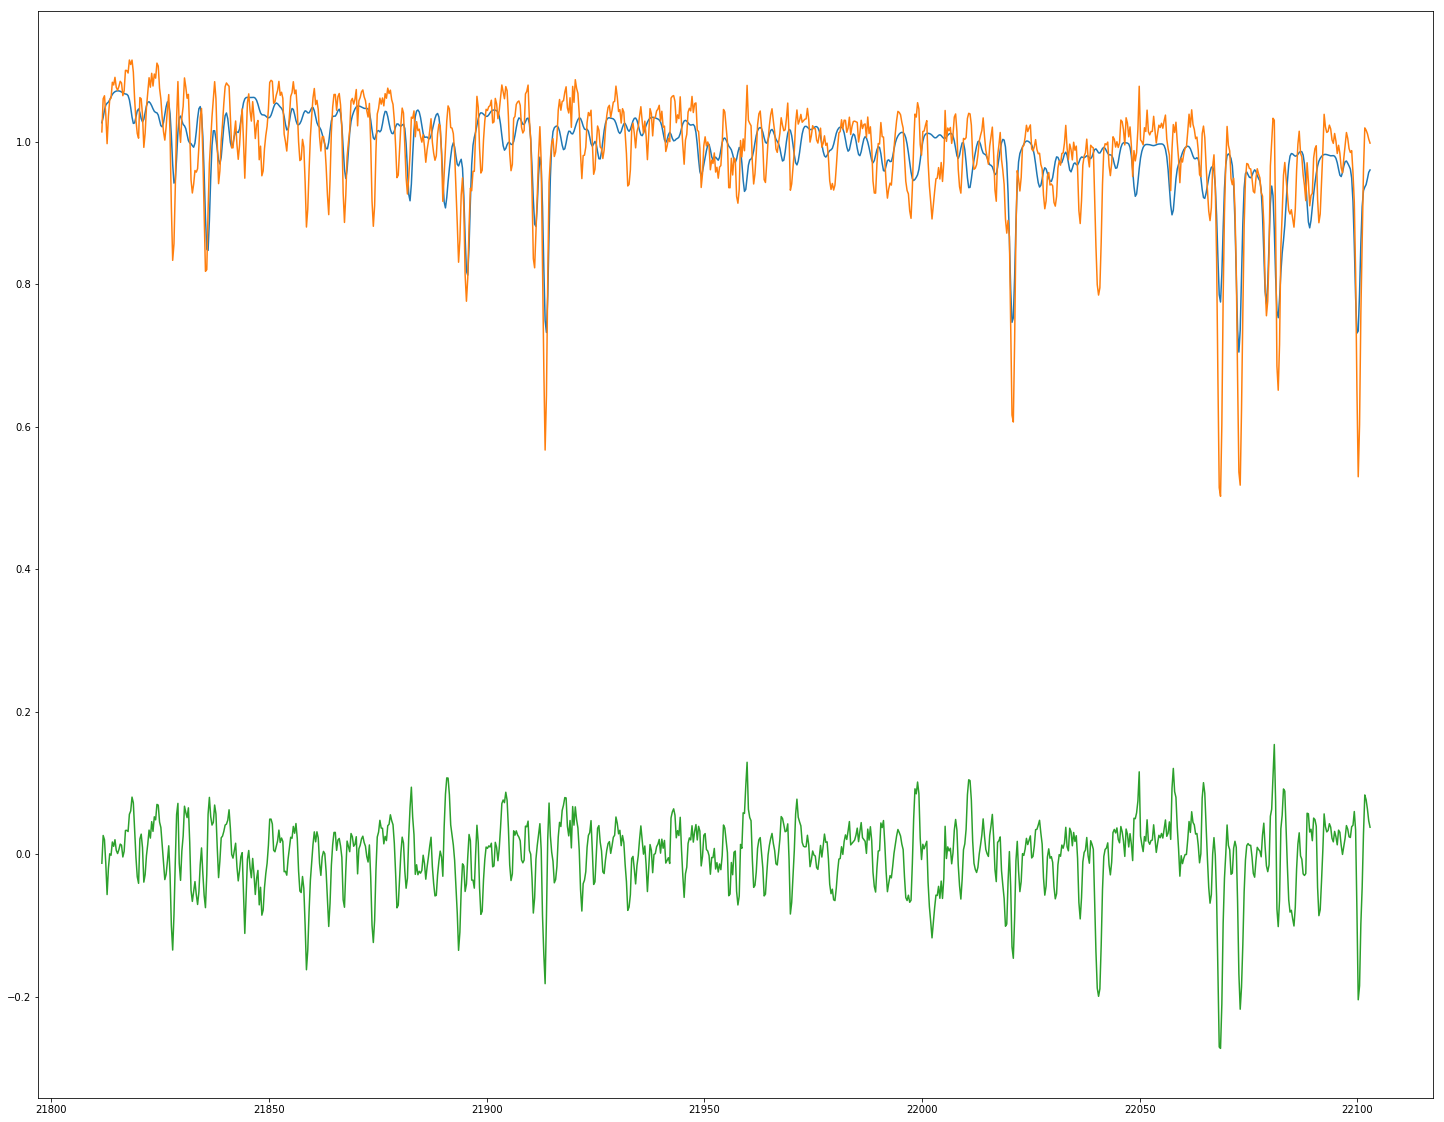

In [5]:
#This cell first sets the model to the best fit parameters, and then produces wavelength/flux lists for plotting
# as other. Slope values for the changes in flux at each wavelength are generated for changes in [M/H], as are 
# unmasked model-data residuals. Includes a plot at the end of best-fot model, data and residuals


import model_tester_updated as mt

from scipy import signal 


print "chi squared val ", like1


for a in gc_result.median.keys():
    setattr(model,a,gc_result.median[a])
    
w, f = model()

print 
slopes = mt.find_slopes(model, 'mh', np.arange(-0.5,0.8,0.1))
plt.figure(figsize=(25,20))
residual_flux = mt.calc_residuals(f,starspectrum35.flux.value)
print fit_model.mh_0.value


plt.plot(w,f)
plt.plot(starspectrum35.wavelength.value,starspectrum35.flux.value)
plt.plot(w,residual_flux)


In [6]:
#This cell creates a data spectum with all regions where flux deviates from 1. by more than 5%. S_lambda
# and R values for the model are also produced.


five_percent_masked_flux, five_percent_masked_wavelength, five_percent_masked_uncert = mt.make_mask_between_limit(starspectrum35.flux.value,starspectrum35.wavelength.value,starspectrum35.uncertainty.value,0.05)

five_percent = SKSpectrum1D.from_array(wavelength=five_percent_masked_wavelength*u.angstrom, flux=five_percent_masked_flux*u.Unit('erg/s/cm^2/angstrom'), uncertainty=five_percent_masked_uncert*u.Unit('erg/s/cm^2/angstrom'))

#sl_hold = sl_mh

sl_mh = mt.s_lambda(model,'mh',model.mh_0.value,0.1)

sl_teff = mt.s_lambda(model,'teff',model.teff_0.value,100)

R = mt.r_val_polynomial(model)


968 618


968 968


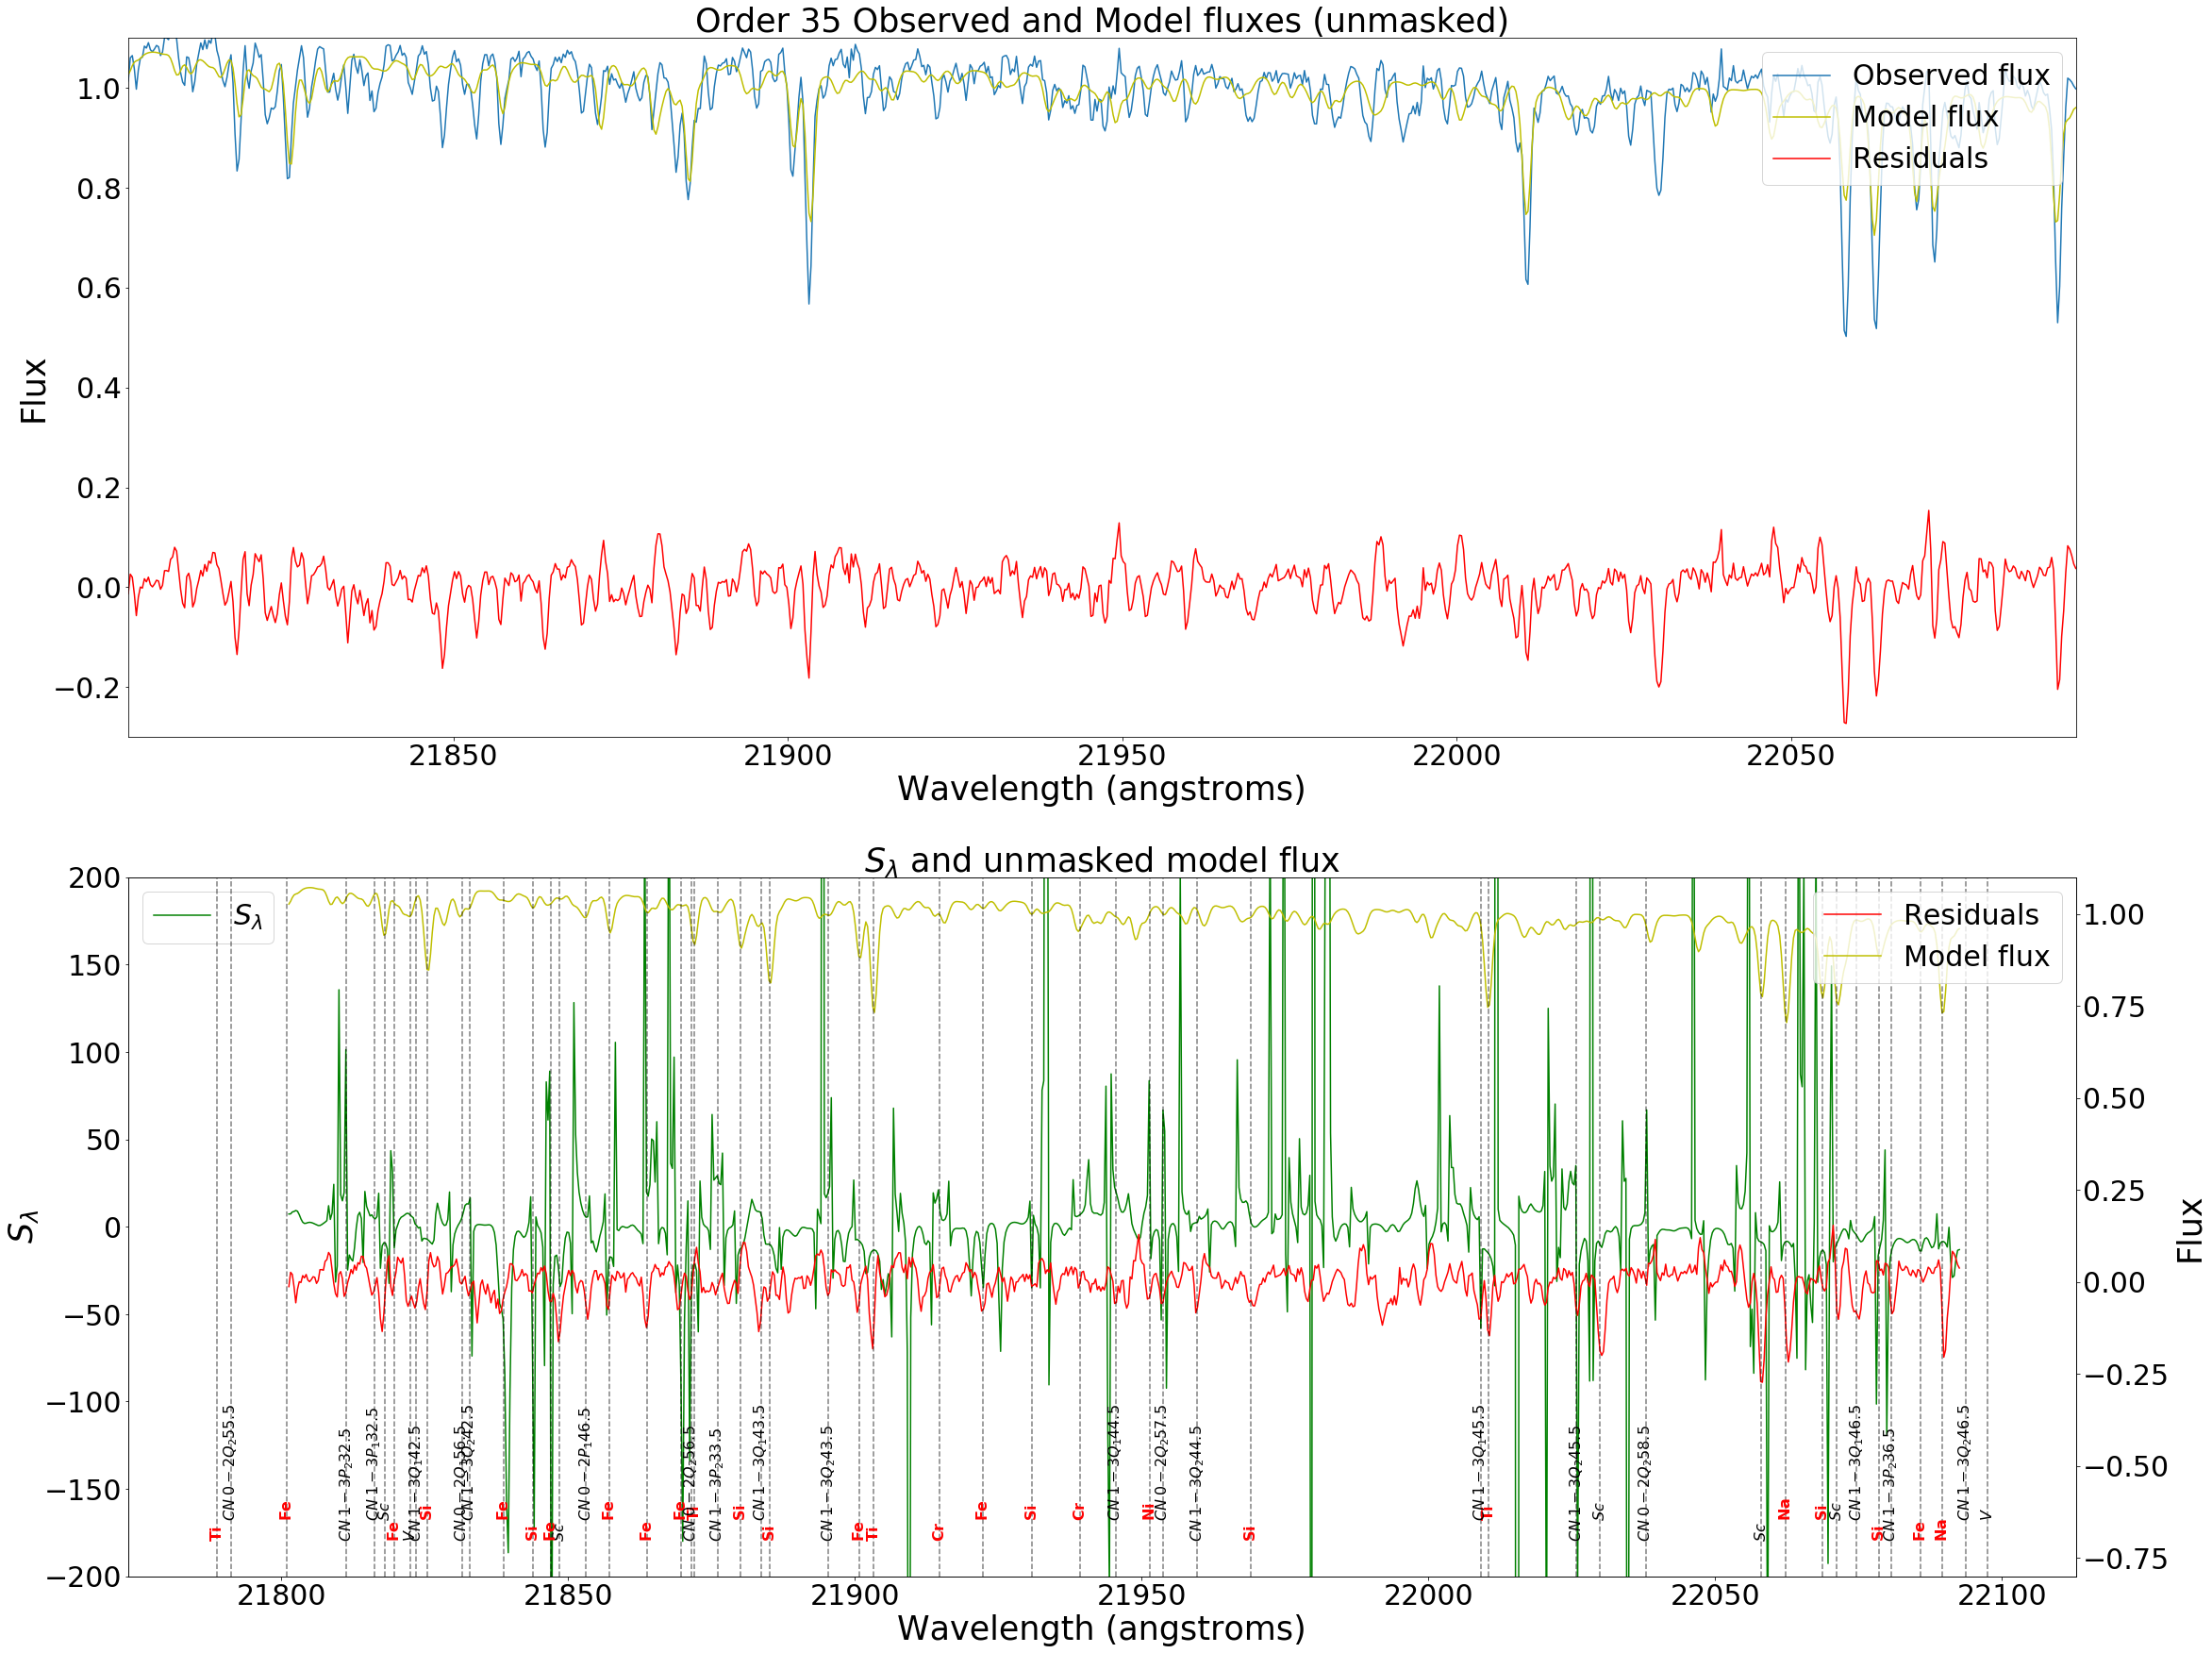

In [46]:
#Makes plots of observed, model, and residual fluxes, and S_lambda, model, and residuals.

plt.figure(figsize=(37,30))

residuals = starspectrum35.flux.value - f

ax = [plt.subplot(2,1,i+1) for i in range(2)]
ax[0].set_xlim(np.amin(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0),np.amax(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0))
ax2b = ax[1].twinx()
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)
ax2b.tick_params(axis='both', which='major', labelsize=30)

ax[1].set_ylim(-200,200)
ax[1].plot(w/(gc_result.median['vrad_2']/3e5+1.0),sl_mh,color='g',label='$S_{\lambda}$')
#ax2b.plot([0],[0],color='g',label='$S_{\lambda}$')
ax2b.plot(w/(gc_result.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
ax2b.plot(w/(gc_result.median['vrad_2']/3e5+1.0),f, color='y',label='Model flux')
ax[1].set_xlabel("Wavelength (angstroms)", size=35)
ax2b.set_ylim(-0.8,1.1)
ax[1].set_title("$S_{\lambda}$ and unmasked model flux", size=35)
ax2b.set_ylabel("Flux", size=35)
ax2b.legend(loc='upper right',fontsize=30.)
ax[1].legend(loc='upper left',fontsize=30.)

#ax[0].plot(five_percent.wavelength/(gc_result.median['vrad_2']/3e5+1.0),five_percent.flux)
ax[0].plot(starspectrum35.wavelength/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
ax[0].plot(w/(gc_result.median['vrad_2']/3e5+1.0),f, color='y',label='Model flux')
ax[0].plot(w/(gc_result.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
ax[0].set_xlabel("Wavelength (angstroms)", size=35)
ax[0].set_ylabel("Flux", size=35)
ax[0].set_ylim(-0.3,1.1)
ax[0].set_title("Order 35 Observed and Model fluxes (unmasked)", size=35)
ax[0].legend(loc='upper right',fontsize=30.)




ax[1].set_ylabel("$S_{\lambda}$", size=35)
print len(starspectrum35.wavelength), len(w)
plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=16,highlight=['Fe','Na', 'Si','Ti','Ca','Cr','Ni'])


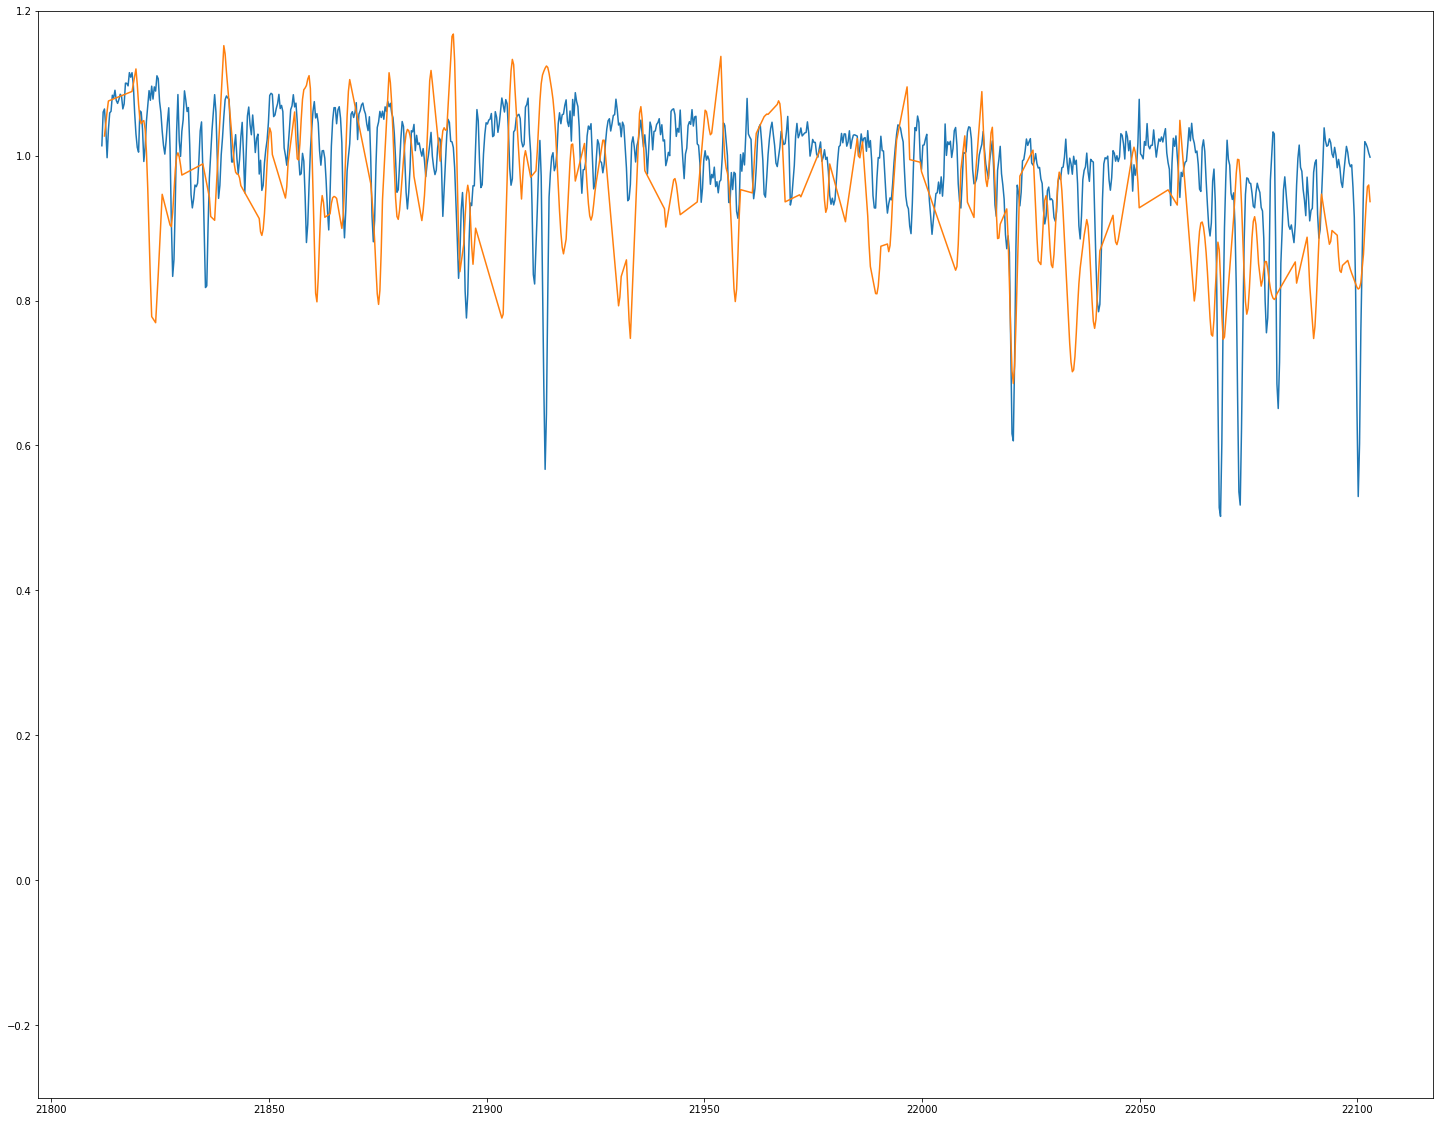

<CompoundModel47(teff_0=2300.0, logg_0=0.0, mh_0=0.5, alpha_0=0.0, vrot_1=[ 10.], limb_darkening_1=0.6, vrad_2=0.0, R_3=24000.0)>

In [53]:
#Makes mask based on S_lambda, and concatenates as before

mask_sl_f = []
mask_sl_w = []
sl_mask_indices = []

for i in range(len(sl_mh)):
    if abs(sl_mh[i])<8.:
        mask_sl_f += [starspectrum35.flux.value[i]]
        mask_sl_w += [starspectrum35.flux.value[i]]
        sl_mask_indices += [i]
        
masked_data_sl_f = np.delete(starspectrum35.flux.value,sl_mask_indices)
masked_data_sl_w = np.delete(starspectrum35.wavelength.value,sl_mask_indices)
masked_data_sl_u = np.delete(starspectrum35.uncertainty.value,sl_mask_indices)

plt.figure(figsize=(25,20))

plt.plot(starspectrum35.wavelength,starspectrum35.flux)
#plt.plot(masked_data_sl_w,masked_data_sl_f)


masked_data_sl = SKSpectrum1D.from_array(wavelength=masked_data_sl_w*u.angstrom, flux=masked_data_sl_f*u.Unit('erg/s/cm^2/angstrom'), uncertainty=masked_data_sl_f*u.Unit('erg/s/cm^2/angstrom'))



interp_sl = Interpolate(masked_data_sl)
convolve_sl = InstrumentConvolveGrating.from_grid(g,R=24000)
rot_sl = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
norm_sl = Normalize(masked_data_sl,2)
like_sl = Chi2Likelihood(masked_data_sl)
                         
model = g | rot_sl |DopplerShift(vrad=0.0)| convolve_sl | interp_sl | norm_sl
masked_model_sl = model | like_sl
tw,tf = model()
plt.plot(tw,tf)
plt.ylim(-0.3,1.2)
plt.show()
masked_model_sl

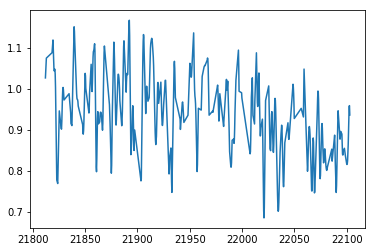

In [48]:
plt.plot(tw,tf)

In [9]:
#Fits S_lambda masked model

gc_result_masked_sl = mt.run_multinest_fit(masked_model_sl)


print "chi squared val ", like_sl


here
here
[starkit.fitkit.multinest.base][INFO   ]  Starting fit in /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpOfCtpe with prefix specgrid_multinest (base.py:307)
[starkit.fitkit.multinest.base][INFO   ]  Fit finished - took 18.91 s (base.py:314)
[starkit.fitkit.multinest.base][INFO   ]  Cleaning up - deleting /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpOfCtpe (base.py:322)
teff_0      4161.146086
logg_0         1.896533
mh_0          -0.283932
alpha_0        0.125997
vrot_1       184.867891
vrad_2        20.443732
R_3        24000.000000
dtype: float64
teff_0      4189.900656
logg_0         1.983714
mh_0          -0.257699
alpha_0        0.133768
vrot_1       181.629167
vrad_2         6.576692
R_3        24000.000000
dtype: float64 end
chi squared val  Model: SpectralChi2Likelihood
Inputs: ('wavelength', 'flux')
Outputs: ('loglikelihood',)
Model set size: 1
Parameters:


<MultiNest Result (median)
teff_0      3891.050138
logg_0         0.103960
mh_0           0.004661
alpha_0        0.306274
vrot_1         0.909221
vrad_2       140.604152
R_3        24000.000000
dtype: float64>
<MultiNest Result (median)
teff_0      4161.146086
logg_0         1.896533
mh_0          -0.283932
alpha_0        0.125997
vrot_1       184.867891
vrad_2        20.443732
R_3        24000.000000
dtype: float64>
968 493


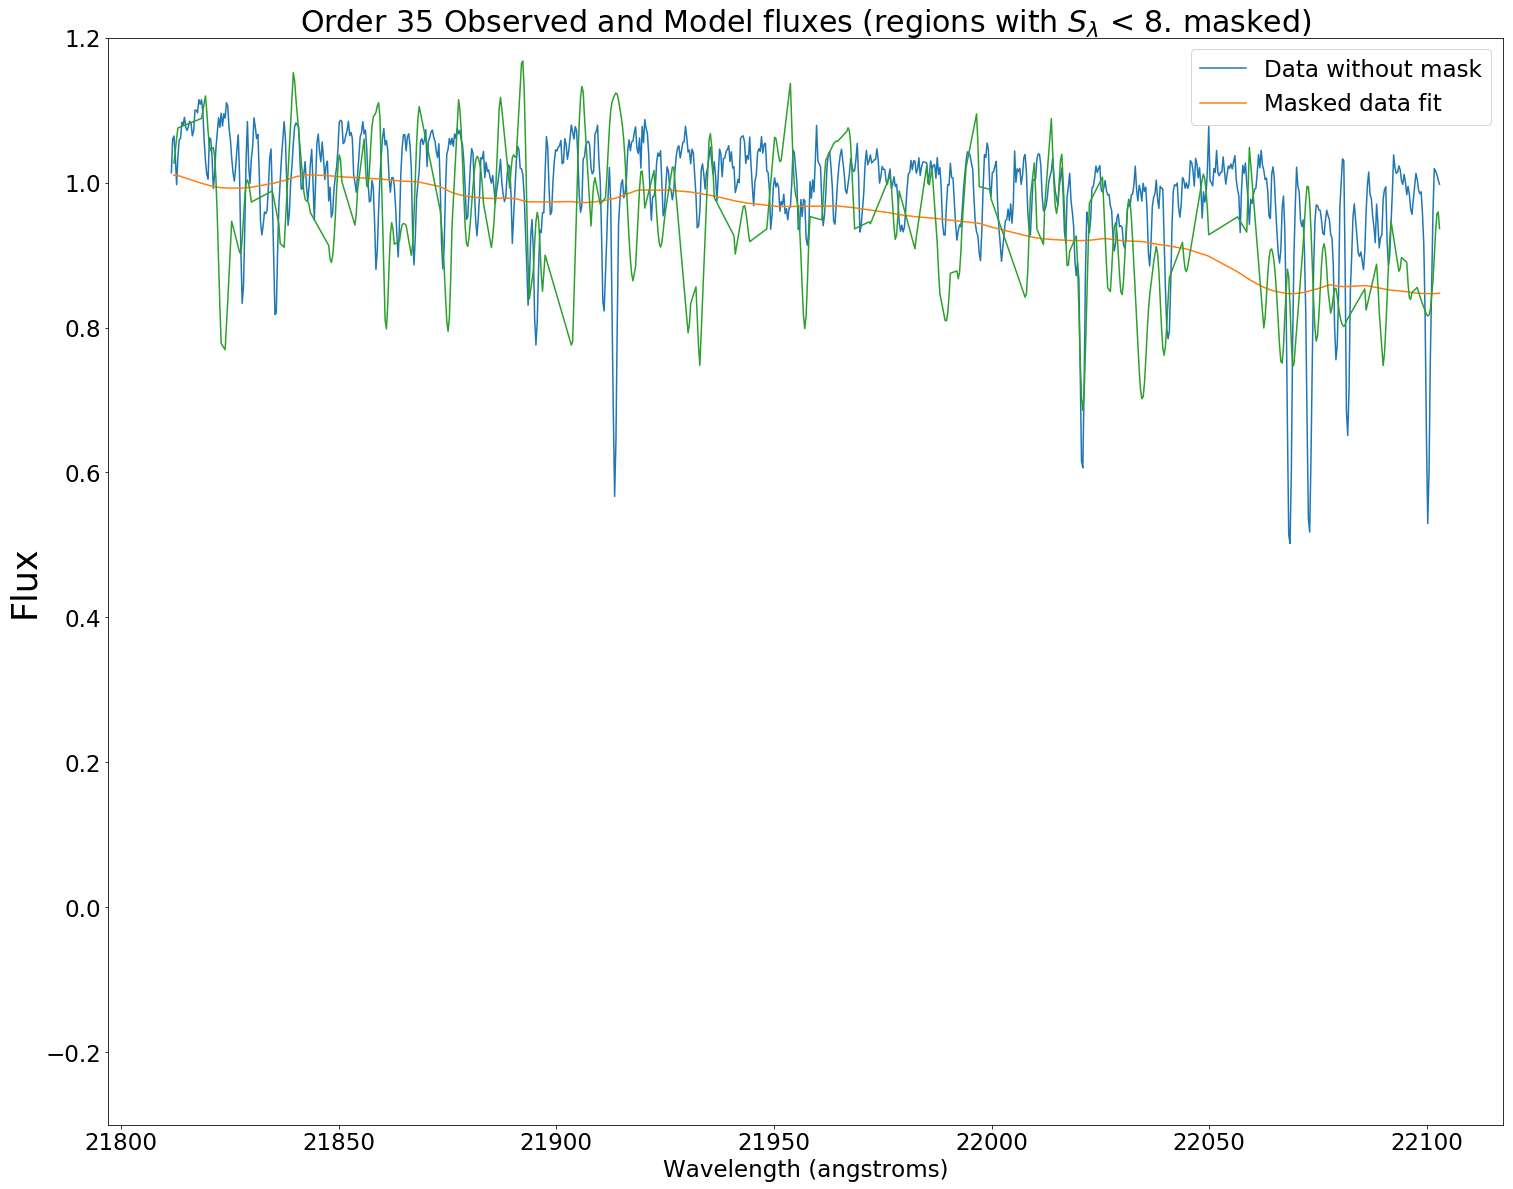

In [55]:
#Makes plots of S_lambda masked model

print gc_result

print gc_result_masked_sl

for a in gc_result_masked_sl.median.keys():
    setattr(model,a,gc_result_masked_sl.median[a])

sl_w,sl_f = model()

print len(starspectrum35.flux.value), len(masked_data_sl_f)

model_residual = signal.resample(f,50000) - signal.resample(sl_f,50000)

res_w = np.linspace(np.amin(w),np.amax(w),50000)
res_sl_w = np.linspace(np.amin(sl_w),np.amax(sl_w),50000)

plt.figure(figsize=(25,20))

plt.plot(starspectrum35.wavelength.value, starspectrum35.flux.value,label="Data without mask")
#plt.plot(masked_data_sl_w, masked_data_sl_f,label="Data with mask applied")


plt.plot(sl_w,sl_f, label="Masked data fit")
plt.plot(tw,tf)
plt.xlabel("Wavelength (angstroms)", size=23)
plt.ylabel("Flux", size=35)
plt.ylim(-0.3,1.2)
plt.title("Order 35 Observed and Model fluxes (regions with $S_{\lambda}$ < 8. masked)", size=30)
plt.legend(loc='upper right', fontsize=23.)
plt.tick_params(axis='both', which='major', labelsize=23)
#plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=16,highlight=['Fe','Na', 'Si','Ti','Ca','Cr','Ni'])


In [11]:

interp_5p = Interpolate(five_percent)
convolve_5p = InstrumentConvolveGrating.from_grid(g,R=24000)
rot_5p = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
norm_5p = Normalize(five_percent,2)
like_5p = Chi2Likelihood(five_percent)
                         
model = g | rot_5p |DopplerShift(vrad=0.0)| convolve_5p | interp_5p | norm_5p
masked_model_5p = model | like_5p

masked_model_5p


<CompoundModel17(teff_0=2300.0, logg_0=0.0, mh_0=0.5, alpha_0=0.0, vrot_1=[ 10.], limb_darkening_1=0.6, vrad_2=0.0, R_3=24000.0)>

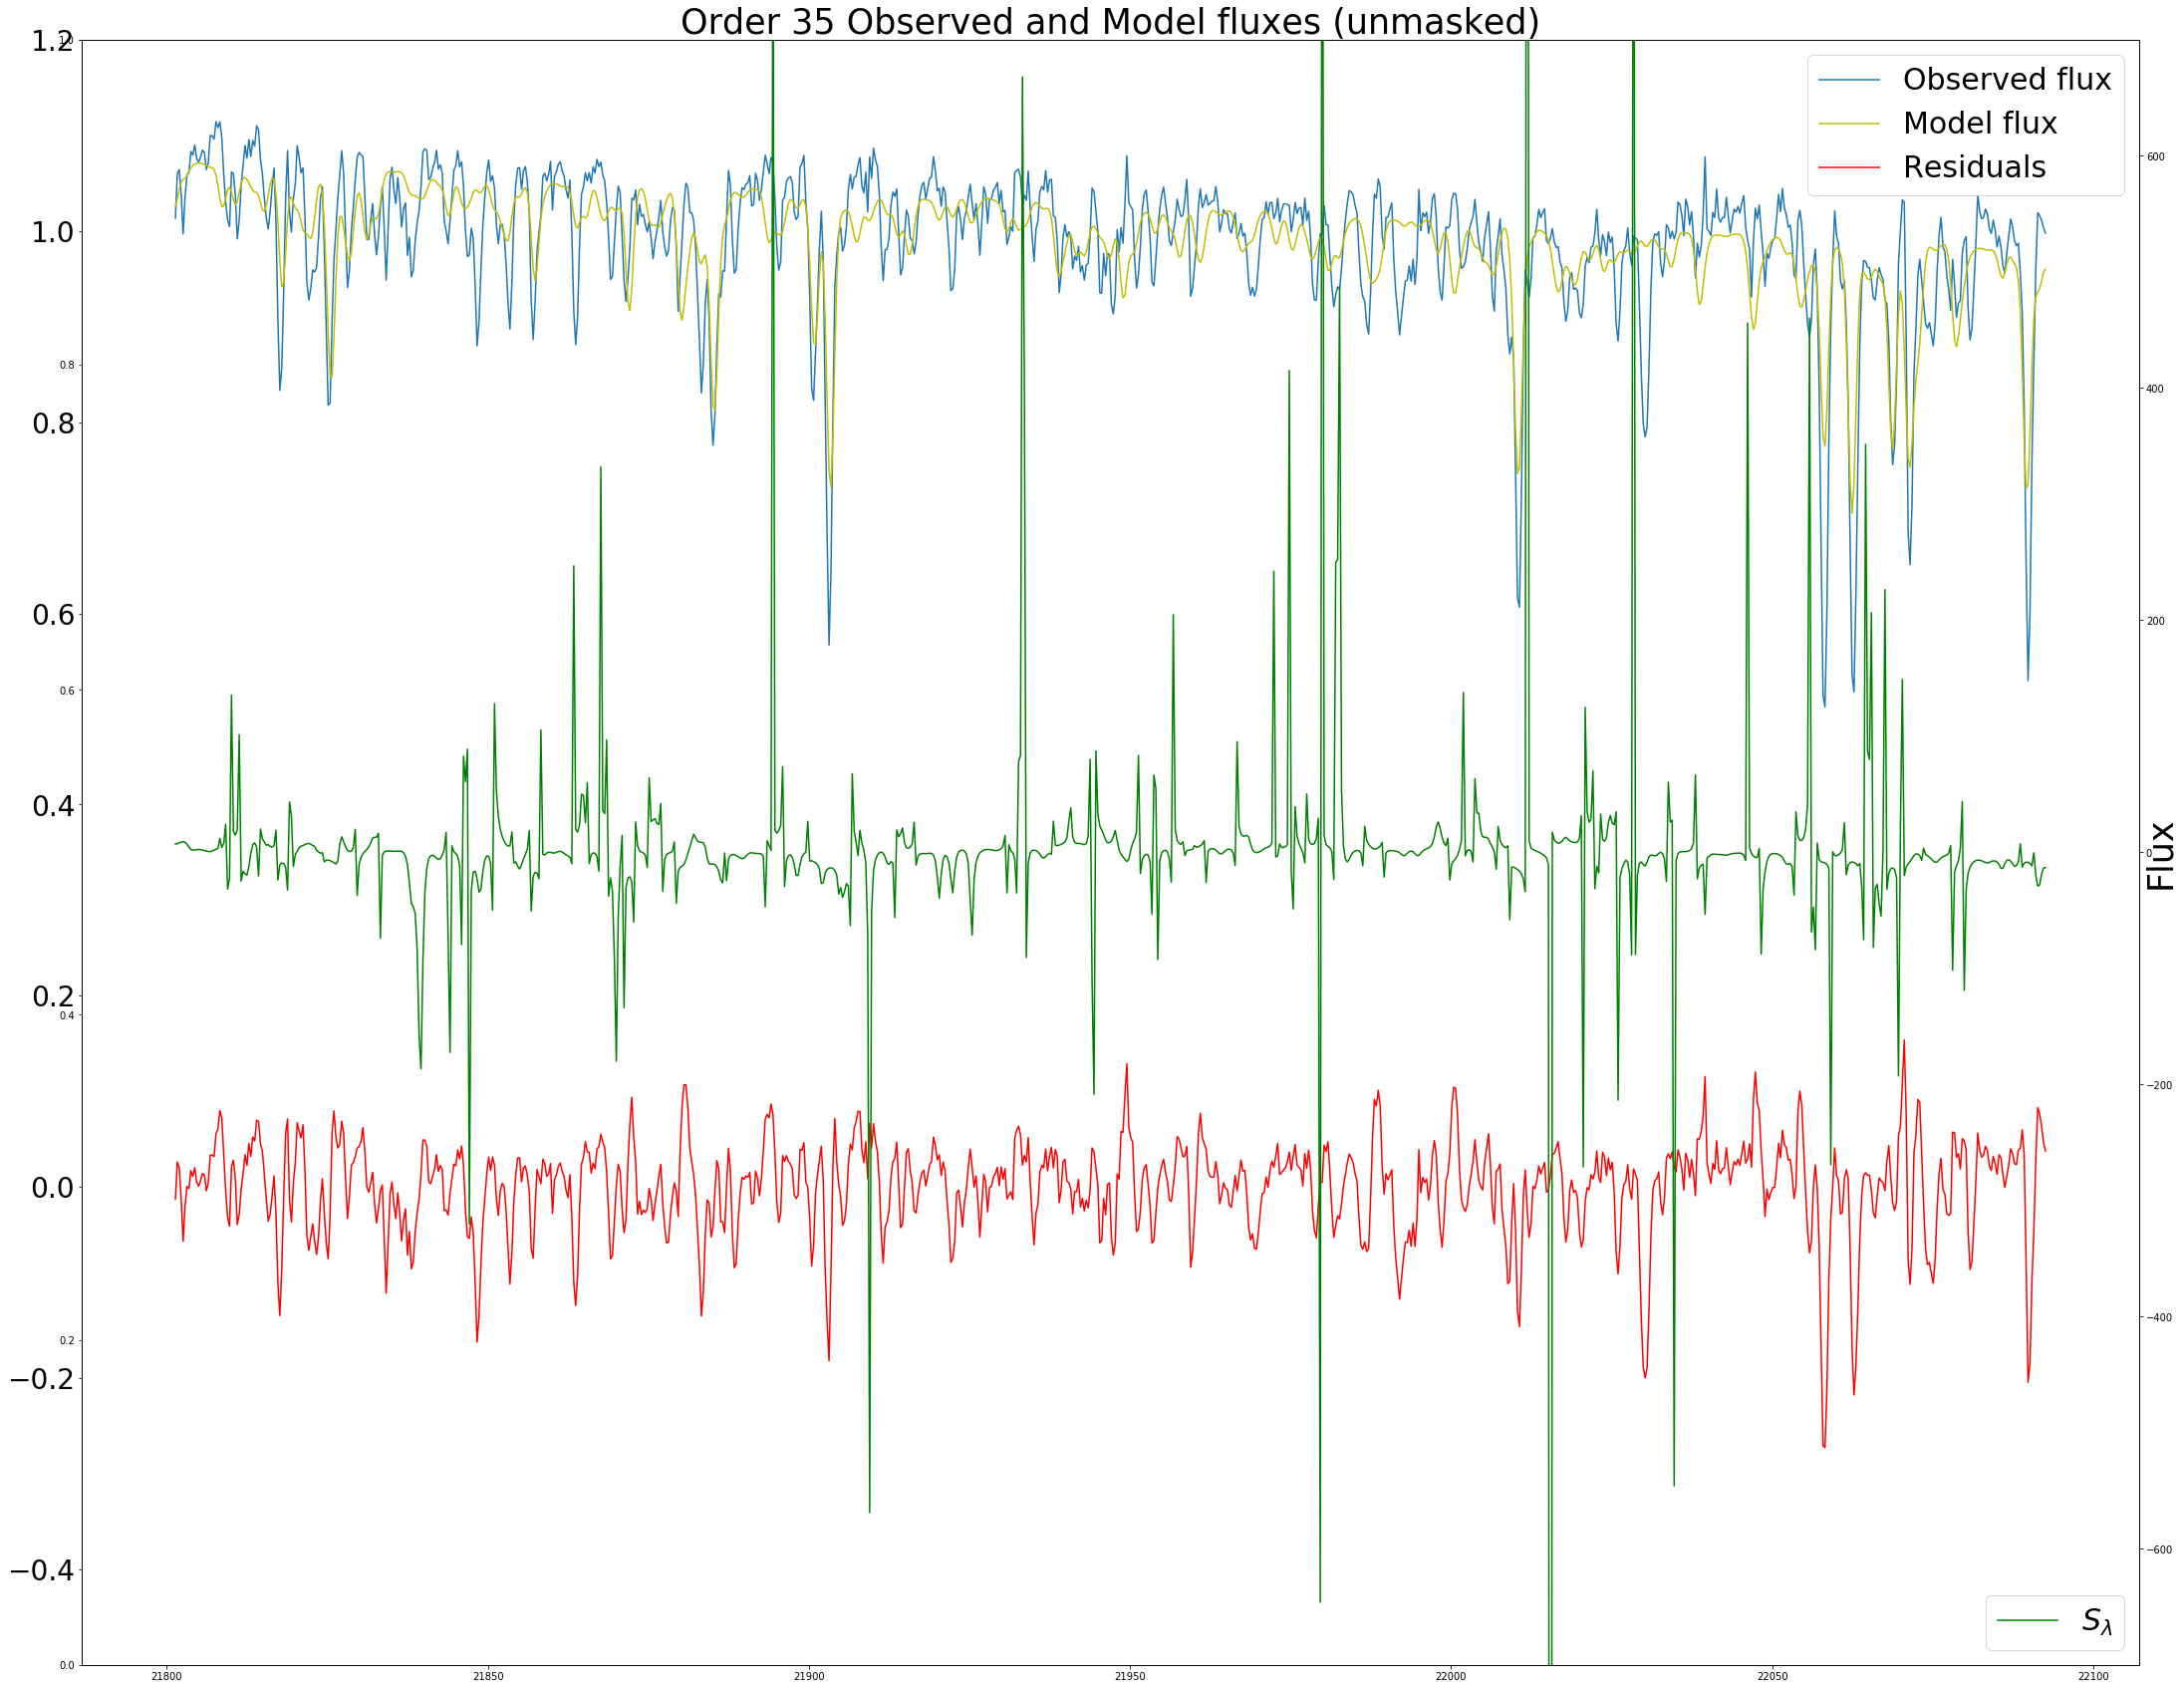

In [42]:

plt.figure(figsize=(37,30))

plt1 = plt.twinx()
ax2 = plt.twinx()
plt1.tick_params(axis='both', which='major', labelsize=28)

plt1.plot(starspectrum35.wavelength/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
plt1.plot(w/(gc_result.median['vrad_2']/3e5+1.0),f, color='y',label='Model flux')
plt1.plot(w/(gc_result.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
ax2.plot(w/(gc_result.median['vrad_2']/3e5+1.0),sl_mh,color='g',label='$S_{\lambda}$')
plt1.set_xlabel("Wavelength (angstroms)", size=35)
plt1.set_ylabel("Flux", size=35)

ax2.set_ylim(-700,700)
plt1.set_ylim(-0.5,1.2)
plt.title("Order 35 Observed and Model fluxes (unmasked)", size=35)
#plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=24,highlight=['Fe','Na', 'Si','Ti','Ca','Cr','Ni'])
plt1.legend(loc='upper right', fontsize=30)
ax2.legend(loc='lower right', fontsize=30)

In [12]:
gc_result_masked_5p = mt.run_multinest_fit(masked_model_5p)

for a in gc_result_masked_5p.median.keys():
    setattr(model,a,gc_result_masked_5p.median[a])

fivep_w,fivep_f = model()

here
here
[starkit.fitkit.multinest.base][INFO   ]  Starting fit in /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpaBDc6t with prefix specgrid_multinest (base.py:307)
[starkit.fitkit.multinest.base][INFO   ]  Fit finished - took 142.53 s (base.py:314)
[starkit.fitkit.multinest.base][INFO   ]  Cleaning up - deleting /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpaBDc6t (base.py:322)
teff_0      5607.642514
logg_0         2.096619
mh_0          -0.986275
alpha_0        0.276693
vrot_1       104.215639
vrad_2       934.799489
R_3        24000.000000
dtype: float64
teff_0      5548.659575
logg_0         2.107005
mh_0          -0.974418
alpha_0        0.238327
vrot_1       135.747430
vrad_2       584.154897
R_3        24000.000000
dtype: float64 end


5607.6425141 4028.0 329.077349575 69.3
0.27669257499 0.37 0.201754924936 0.024
-0.986275295279 0.3 0.284486878527 0.021
2.09661921268 1.63 1.23168633801 0.08
{'logg_0': (1.2862694556290901, 1.0034838367497902), 'teff_0': (1.3921654702324306, 1.042089847957508), 'mh_0': (-3.2875843175950377, -1.0290255457714512), 'alpha_0': (0.74781777024351404, 1.0039489270129334)}


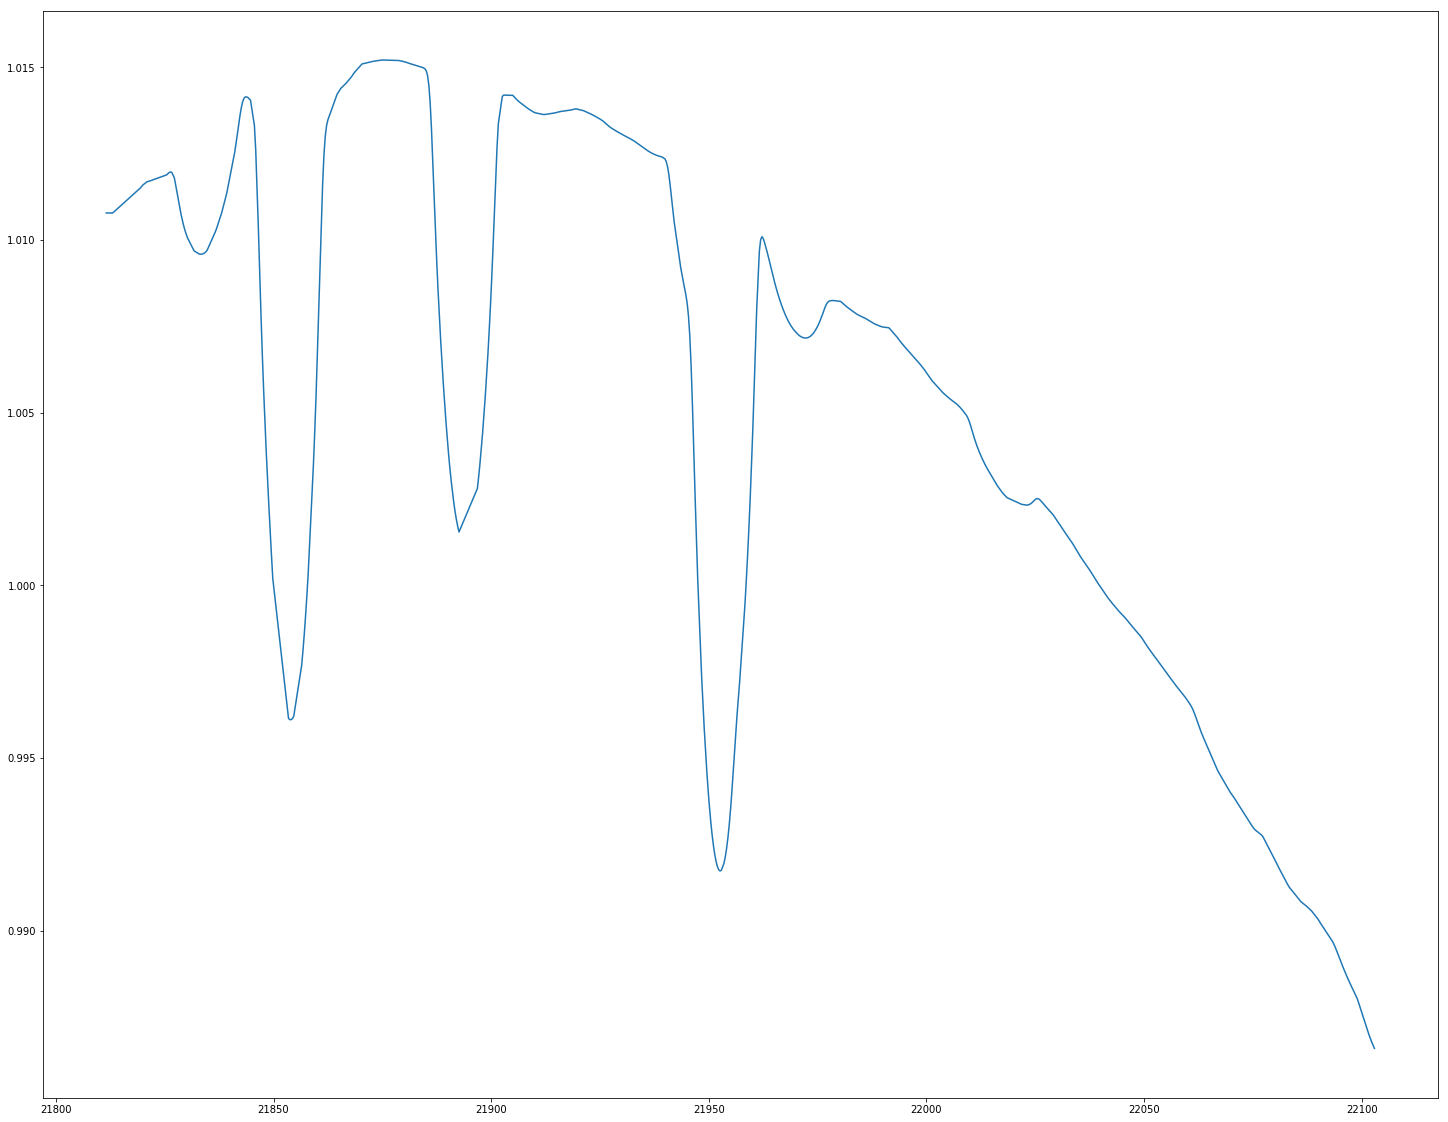

In [13]:
plt.figure(figsize=(25,20))
plt.plot(fivep_w, fivep_f)

NGC6791_J19205_3748282 = {
    "teff_0" : (4028., 69.3),
    "logg_0" : (1.63, 0.08),
    "mh_0" : (0.3, 0.021),
    "alpha_0" : (0.37, 0.024)

}


sigmas_5p = {}

sigmabounds_5p = gc_result_masked_5p.calculate_sigmas(1)
for a in sigmabounds_5p.keys():
    sigmas_5p[a] = (sigmabounds_5p[a][1] - sigmabounds_5p[a][0])*0.5
    
nsigma_5p = {}

for a in NGC6791_J19205_3748282.keys():
    print gc_result_masked_5p.median[a],NGC6791_J19205_3748282[a][0],sigmas_5p[a],NGC6791_J19205_3748282[a][1]
    nsigma_5p[a] = (gc_result_masked_5p.median[a]/NGC6791_J19205_3748282[a][0], 
                    gc_result_masked_5p.median[a]/sigmas_5p[a]*
                    np.sqrt((sigmas_5p[a]/gc_result_masked_5p.median[a])**2+
                    (NGC6791_J19205_3748282[a][1]/NGC6791_J19205_3748282[a][0])**2))
    
print nsigma_5p
#gc_result_masked_5p.plot_triangle(parameters=['teff_0','logg_0','mh_0','alpha_0','vrot_1','vrad_2'])

In [14]:
plt.figure(figsize=(37,15))

residuals_5p = starspectrum35.flux.value - fivep_f

ax5p = plt.subplot(1,1,1)
ax5p.set_xlim(np.amin(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0),np.amax(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0))

ax5p.tick_params(axis='both', which='major', labelsize=30)

#ax[0].plot(five_percent.wavelength/(gc_result.median['vrad_2']/3e5+1.0),five_percent.flux)
ax5p.plot(starspectrum35.wavelength/(gc_result_masked_5p.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
ax5p.plot(fivep_w/(gc_result_masked_5p.median['vrad_2']/3e5+1.0),fivep_f, color='y',label='Model flux')
ax5p.plot(fivep_w/(gc_result_masked_5p.median['vrad_2']/3e5+1.0),residuals_5p, color='r',label='Residuals')
ax5p.set_xlabel("Wavelength (angstroms)", size=35)
ax5p.set_ylabel("Flux", size=35)
ax5p.set_ylim(-0.3,1.1)
ax5p.set_title("Order 35 Observed and Model fluxes (5% mask)", size=35)
ax5p.legend(loc='upper right', fontsize=30.)


ValueError: operands could not be broadcast together with shapes (968,) (618,) 

<Figure size 2664x1080 with 0 Axes>

In [ ]:
plt.figure(figsize=(37,15))
axsl = plt.subplot(1,1,1)
axsl.set_xlim(np.amin(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0),np.amax(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0))

axsl.tick_params(axis='both', which='major', labelsize=30)

#residuals_sl = starspectrum35.flux.value - sl_f

axsl.plot(masked_data_sl.wavelength/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),masked_data_sl.flux, 'go')
axsl.plot(starspectrum35.wavelength/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
axsl.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),sl_f, 'yo',label='Model flux')
#axsl.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
axsl.set_xlabel("Wavelength (angstroms)", size=35)
axsl.set_ylabel("Flux", size=35)
axsl.set_ylim(-0.3,1.1)
axsl.set_title("Order 35 Observed and Model fluxes ($S_{\lambda}$ > 10. mask)", size=35)
axsl.legend(loc='upper right', fontsize=30.)

In [ ]:
plt.figure(figsize=(37,15))
axsl = plt.subplot(1,1,1)
axsl.set_xlim(np.amin(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0),np.amax(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0))

axsl.tick_params(axis='both', which='major', labelsize=30)

residuals_sl = starspectrum35.flux.value - sl_f

#ax[0].plot(five_percent.wavelength/(gc_result.median['vrad_2']/3e5+1.0),five_percent.flux)
axsl.plot(starspectrum35.wavelength/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
axsl.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),sl_f, color='y',label='Model flux')
axsl.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
axsl.set_xlabel("Wavelength (angstroms)", size=35)
axsl.set_ylabel("Flux", size=35)
axsl.set_ylim(-0.3,1.1)
axsl.set_title("Order 35 Observed and Model fluxes ($S_{\lambda}$ > 10. mask)", size=35)
axsl.legend(loc='upper right', fontsize=30.)

In [ ]:
plt.figure(figsize=(37,15))
axall = plt.subplot(1,1,1)
axall.set_xlim(np.amin(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0),np.amax(starspectrum35.wavelength.value)/(gc_result.median['vrad_2']/3e5+1.0))

axall.tick_params(axis='both', which='major', labelsize=30)

residuals_sl = starspectrum35.flux.value - sl_f

#ax[0].plot(five_percent.wavelength/(gc_result.median['vrad_2']/3e5+1.0),five_percent.flux)
axall.plot(starspectrum35.wavelength/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),starspectrum35.flux,label='Observed flux')
axall.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),sl_f, color='y',label='Model flux')
axall.plot(sl_w/(gc_result_masked_sl.median['vrad_2']/3e5+1.0),residuals, color='r',label='Residuals')
axall.set_xlabel("Wavelength (angstroms)", size=35)
axsl.set_ylabel("Flux", size=35)
axsl.set_ylim(-0.3,1.1)
axsl.set_title("Order 35 Observed and Model fluxes ($S_{\lambda}$ > 10. mask)", size=35)
axsl.legend(loc='upper right', fontsize=30.)

In [ ]:
plt.figure(figsize=(25,20))
ax = [plt.subplot(5,1,i+1) for i in range(5)]

#ax2 = ax1.twinx()
#ax1.set_ylim(-0.4,2.3)
#ax2.set_ylim(-0.4,0.6)

plt.subplots_adjust(wspace=0, hspace=0)

res_f2 = starspectrum35.flux.value - signal.resample(f, len(starspectrum35.flux.value))
print len(starspectrum35.flux.value),len(f)

#ax3.set_xlim(starspectrum35.wavelength.value[0]/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.wavelength.value[-1]/(gc_result.median['vrad_2']/3e5+1.0)) 
ax[0].plot(starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux.value, label='Observed Flux') 
ax[1].plot(w/(gc_result.median['vrad_2']/3e5+1.0),f, label='Model Flux',color='y') 
ax[2].plot(starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0),residual_flux,color='g',label='Residuals')
ax[3].plot(w/(gc_result.median['vrad_2']/3e5+1.0),np.array(slopes),color='c', label='Slopes') 
ax[4].plot(w/(gc_result.median['vrad_2']/3e5+1.0),R,color='y', label='R') 

for i in range(5):
    ax[i].legend(loc=1,prop={'size': 15})
    ax[i].set_xlim(starspectrum35.wavelength.value[0]/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.wavelength.value[-1]/(gc_result.median['vrad_2']/3e5+1.0)) 
    
ax[0].set_ylim(0.4,1.2)
ax[1].set_ylim(0.4,1.2)
ax[2].set_ylim(-0.4,0.4)
ax[3].set_ylim(-0.3,0.1)



ax[0].axhline(y=1+np.std(starspectrum35.flux.value),alpha=0.5,color='r')
ax[0].axhline(y=1,alpha=0.5,color='k')
ax[0].axhline(y=1-np.std(starspectrum35.flux.value),alpha=0.5,color='r')

#plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=16,highlight=['Fe'])
ax[1].axhline(y=1.05,alpha=0.5,color='r')
ax[1].axhline(y=1.,alpha=0.5,color='k')
ax[1].axhline(y=0.95,alpha=0.5,color='r')

ax[2].axhline(y=0.05,alpha=0.5,color='r')
ax[2].axhline(y=0.,alpha=0.5,color='k')
ax[2].axhline(y=-0.05,alpha=0.5,color='r')

ax[3].axhline(y=1*np.std(slopes),alpha=0.5,color='r')
ax[3].axhline(y=0,alpha=0.5,color='k')
ax[3].axhline(y=-1*np.std(slopes),alpha=0.5,color='r')



#ax2.legend(loc=2,prop={'size': 15})


